## libs

In [11]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import scipy.integrate as integrate
from pathlib import Path

## initialization

In [12]:
def interpolate(a,b,c):
    func = interp1d(a, b)
    return func(c)

def gauss(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d


def gauss_double(x, a, b, c, d, e, f, g):
    return a * np.exp(-(x - b)**2 / c) + d + e * np.exp(-(x - f)**2 / g)

In [92]:
MODEL_DIRECTORY = Path('../model/')
i = 1

## definition of binaries fraction

creating two sets with binaries and singles,
separation with the help of our method, 
approximation profile with TWO gauss function,
then counting bianries via profile integration.

In [97]:
model_list = pd.read_excel(MODEL_DIRECTORY / 'model_list.xlsx')

for index in range(0, len(model_list)):
    NUMBER_STARS = model_list.loc[index, 'num_stars']
    ALPHA = model_list.loc[index, 'alpha']
    
    singles_true = pd.DataFrame(columns=['x','y'])
    binaries_true = pd.DataFrame(columns=['x','y'])

    NUMBER_BINARIES = int(ALPHA * NUMBER_STARS)
    NUMBER_SINGLES = NUMBER_STARS - NUMBER_BINARIES

    singles_true['x'] = np.random.random(size=NUMBER_SINGLES)
    singles_true['y'] = 0.5 * singles_true['x'] + np.random.normal(loc=1.0, scale=0.3, size=NUMBER_SINGLES)

    binaries_true['x'] = np.random.random(size=NUMBER_BINARIES)
    binaries_true['y'] = 0.5 * binaries_true['x'] + np.random.normal(loc=0, scale=0.3, size=NUMBER_BINARIES)

    all_stars = pd.concat([singles_true, binaries_true])

#     all_stars['y'].plot.hist(bins=30)

#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.scatter(all_stars['x'], all_stars['y'], alpha=0.2)
#     ax.plot([0,1],[0.5, 1], c='black')

    line = pd.DataFrame(data={'x' : all_stars['x'], 'y' : [0.5] * len(all_stars)})

    all_stars['detection'] = 'single'
    all_stars.loc[all_stars['y'] > 0.5 * all_stars['x'] + 0.5,'detection'] = 'binary'

#     all_stars[all_stars['detection']=='single']['y'].plot.hist()

    singles_detected = all_stars[all_stars['detection'] =='single']
    binaries_detected = all_stars[all_stars['detection'] =='binary']

    degree = 2
    popt = np.polyfit(singles_detected['x'], singles_detected['y'], degree)
    func_iso = np.poly1d(popt)

    isochrone = pd.DataFrame(data = {'x' : np.linspace(singles_detected['x'].min()-0.05, 
                                                           singles_detected['x'].max()+0.05, 500)})
    isochrone['y'] = func_iso(isochrone['x'])

    singles_detected['y_new'] = singles_detected['y'] - func_iso(singles_detected['x'])
    binaries_detected['y_new'] = binaries_detected['y'] - func_iso(binaries_detected['x'])

#     fig, ax1 = plt.subplots(figsize=(7,5))
#     ax1.scatter(singles_detected['x'], singles_detected['y'], alpha=0.2)
#     ax1.scatter(binaries_detected['x'], binaries_detected['y'], alpha=0.2)

#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.scatter(all_stars['x'], all_stars['y'], alpha=0.2)
#     ax.plot(isochrone['x'], isochrone['y'], c='black')

    all_stars = pd.concat([singles_detected, binaries_detected])

    num_stars = len(all_stars)
    profile = pd.DataFrame(data = {'x' : np.linspace(-1, 2, 701)})
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15)
    kde.fit(all_stars[['y_new']].to_numpy())

    profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
    profile['density'] *= num_stars

#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
#     ax.set_xlim(-1, 2)

#     ax.legend(loc='upper right', fontsize=10)
#     ax.set_xlabel('$y_{new}$')

    popt, pcov = curve_fit(gauss_double, profile.iloc[:, 0], profile.iloc[:, 1], maxfev=9000,
                              bounds=([0, 0.7, 0.05, -0.1, 0, -0.3, 0.05],
                                      [27000, 1.2, 0.2, 0.1, 27000, 0.4, 0.2]))
    if popt[0] > popt[5]:
        popt_1 = popt[0:4]
    
    profile_gauss = pd.DataFrame(data={'x': profile['x']})
    profile_gauss['density'] = gauss(profile_gauss['x'], *popt_1)
    
#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(profile['x'], profile['density'], lw = 1.1, color = 'black')
#     ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.1, ls='--', color='darkred', label='_nolabel')
#     ax.set_xlim(-1.2, 2)

#     ax.legend(loc='upper right', fontsize=10)
#     ax.set_xlabel('$G_{new}$')

#     fig, ax = plt.subplots(figsize=(7,5))
#     ax.plot(profile['x'], profile['density'] - profile_gauss['density'], lw = 1.1, color = 'black')
#     ax.set_xlim(-1.2, 2)

#     ax.legend(loc='upper right', fontsize=10)
#     ax.set_xlabel('$G_{new}$')

    difference = profile['density'] - profile_gauss['density']
    difference[difference < 0] = 0

    number_of_multiples = int(integrate.trapz(difference, profile['x']))

    model_list.loc[index, 'alpha_detected'] = number_of_multiples / len(all_stars)
    model_list[f'alpha_detected_{i}'] = model_list['alpha_detected']


    model_list.to_excel(MODEL_DIRECTORY / 'model_list.xlsx', index=False)
i = i + 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## comparing models' binaries fraction with our results

In [98]:
model_list = pd.read_excel(MODEL_DIRECTORY / 'model_list.xlsx')

In [99]:
model_list['alpha_mean'] = model_list.iloc[:, 3:9].mean(axis=1)
model_list['alpha_std'] = model_list.iloc[:, 3:9].std(axis=1)
model_list['alpha_difference'] = np.abs(model_list['alpha_mean'] - model_list['alpha'])

Text(0, 0.5, 'difference between alpha true and detected')

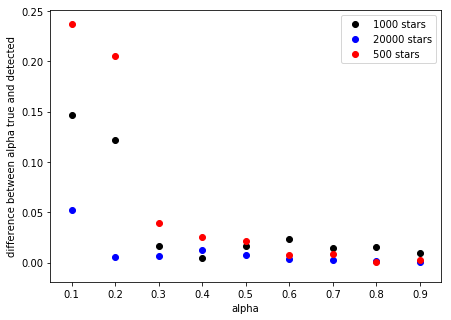

In [100]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(model_list[model_list['num_stars'] == 1000]['alpha'], 
           model_list[model_list['num_stars'] == 1000]['alpha_difference']/model_list[model_list['num_stars'] == 1000]['alpha'],
           c='black', label='1000 stars')
ax.scatter(model_list[model_list['num_stars'] == 20000]['alpha'], 
           model_list[model_list['num_stars'] == 20000]['alpha_difference']/model_list[model_list['num_stars'] == 20000]['alpha'],
           c='blue', label='20000 stars')
ax.scatter(model_list[model_list['num_stars'] == 500]['alpha'], 
           model_list[model_list['num_stars'] == 500]['alpha_difference']/model_list[model_list['num_stars'] == 500]['alpha'],
           c='red', label='500 stars')

ax.legend()
ax.set_xlabel('alpha')
ax.set_ylabel('difference between alpha true and detected')

Text(0, 0.5, 'standart deviation of detected alpha')

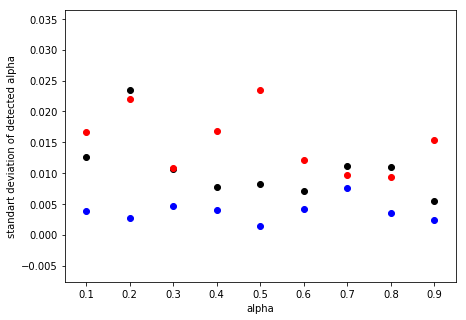

In [101]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(model_list[model_list['num_stars'] == 1000]['alpha'], 
           model_list[model_list['num_stars'] == 1000]['alpha_std'], c='black', label='1000 stars')
ax.scatter(model_list[model_list['num_stars'] == 20000]['alpha'], 
           model_list[model_list['num_stars'] == 20000]['alpha_std'], c='blue', label='20000 stars')
ax.scatter(model_list[model_list['num_stars'] == 500]['alpha'], 
           model_list[model_list['num_stars'] == 500]['alpha_std'], c='red', label='500 stars')

ax.set_xlabel('alpha')
ax.set_ylabel('standart deviation of detected alpha')

Text(0, 0.5, 'dstandart deviation of detected alpha')

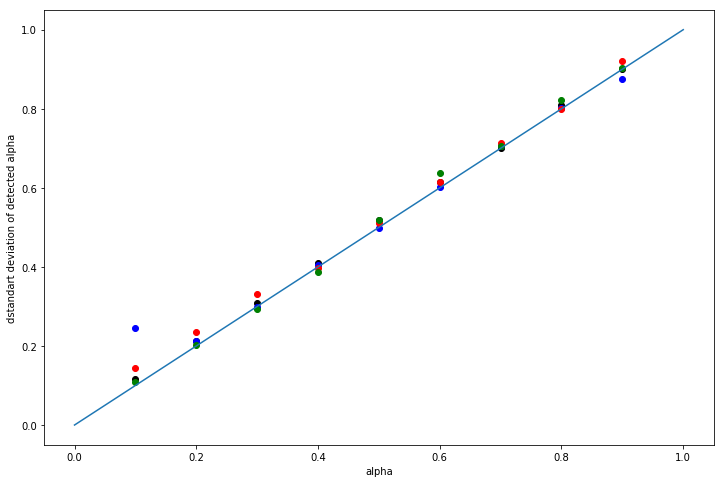

In [81]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(model_list[model_list['num_stars'] == 1000]['alpha'], 
           model_list[model_list['num_stars'] == 1000]['alpha_mean'], c='black', label='1000 stars')
ax.scatter(model_list[model_list['num_stars'] == 20000]['alpha'], 
           model_list[model_list['num_stars'] == 20000]['alpha_mean'], c='blue', label='20000 stars')
ax.scatter(model_list[model_list['num_stars'] == 500]['alpha'], 
           model_list[model_list['num_stars'] == 500]['alpha_mean'], c='red', label='500 stars')
ax.scatter(model_list[model_list['num_stars'] == 1000]['alpha'], 
           model_list[model_list['num_stars'] == 1000]['alpha_detected'], c='green', label='500 stars')
ax.plot([0,1],[0,1])

ax.set_xlabel('alpha')
ax.set_ylabel('dstandart deviation of detected alpha')